In [13]:
import numpy as np
import pandas as pd
import PyMca5.PyMcaCore.SpecFileDataSource as SFDS
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib nbagg

# Load spec and PV files

In [14]:
spec_file = SFDS.SpecFileDataSource('pmnpt_1.spec')
scan = spec_file.getDataObject('257.1')
specdat = scan.getData()

Intdat = np.loadtxt('PVvalue.257', skiprows=1, unpack = True)

# Pull H, L, transmission, average intensity

In [15]:
H = specdat[:,0]
L = specdat[:,2]
trans = specdat[:,31]
AVint = specdat[:,48]


# Extract L positions for each H scan
Lnew = []
for num in range(61):
    Lnew.append(L[num*61])

# First extract 003 RSM scan from log file

In [16]:
log = open('pmnpt_1.log', 'r')
Scan257 = open('Scan257_log.txt','w')

ct = 0
Start = False
for line in log:
    ct+=1
    if 'Scan 257' in line:
        Start = True
    elif 'scan00257' in line:
        break
    if Start == True:
        Scan257.write(line)
   

# Extract the ReadAC (PV writing) lines

In [17]:
Scan257 = open('Scan257_log.txt','r')
ReadACs = open('ReadACS.txt','w')


ct = 0
for line in Scan257:
    ct+=1
    if '/APSshare/epd/rh6-x86/bin/python talk2epics_ReadAC.py' in line:
        ReadACs.write(line)


# Extract lines from repeated PV lines due to attenuator

In [18]:
ReadACs = open('ReadACS.txt','r')
ct=0
LastNum = -2
repeats = []

for line in ReadACs:
    _,_,_,_,Num,_ = line.strip().split()
    if Num == LastNum:
        # If the same point number found, flag previous PV for removal to keep only last PV values
        repeats.append(ct-1)
    LastNum = Num
    ct+=1

# Remove first two attenuator events, didn't write PV values unlike the rest
repeats_corr = repeats[2:]

# Remove bad lines from PVvalues

In [19]:
NewPV = []
ct = 0
IntdatInv = np.swapaxes(Intdat,0,1)

for binset in IntdatInv:
    if ct not in repeats_corr:
        NewPV.append(binset)
    ct+=1

# Correct for transmission

In [20]:
CorrNewPV = []
for dat, tran in zip(NewPV, trans):
    CorrNewPV.append(dat/tran)
CorrNewPV = np.swapaxes(NewPV,0,1)

# Make voltage values

In [21]:
a = [round(val*4/15,2) for val in range(16)]
b = a[::-1]
c = [val*-1 for val in a]
d = c[::-1]
Vs = a + b + c + d

# Remove 0s for log plotting

In [22]:
for x, num in enumerate(CorrNewPV):
    for y, val in enumerate(num):
        if val ==0:
            CorrNewPV[x][y] = 0.1
for x, val in enumerate(AVint):
    if val ==0:
        AVint[x] = 0.1
            

# Make animation

<IPython.core.display.Javascript object>


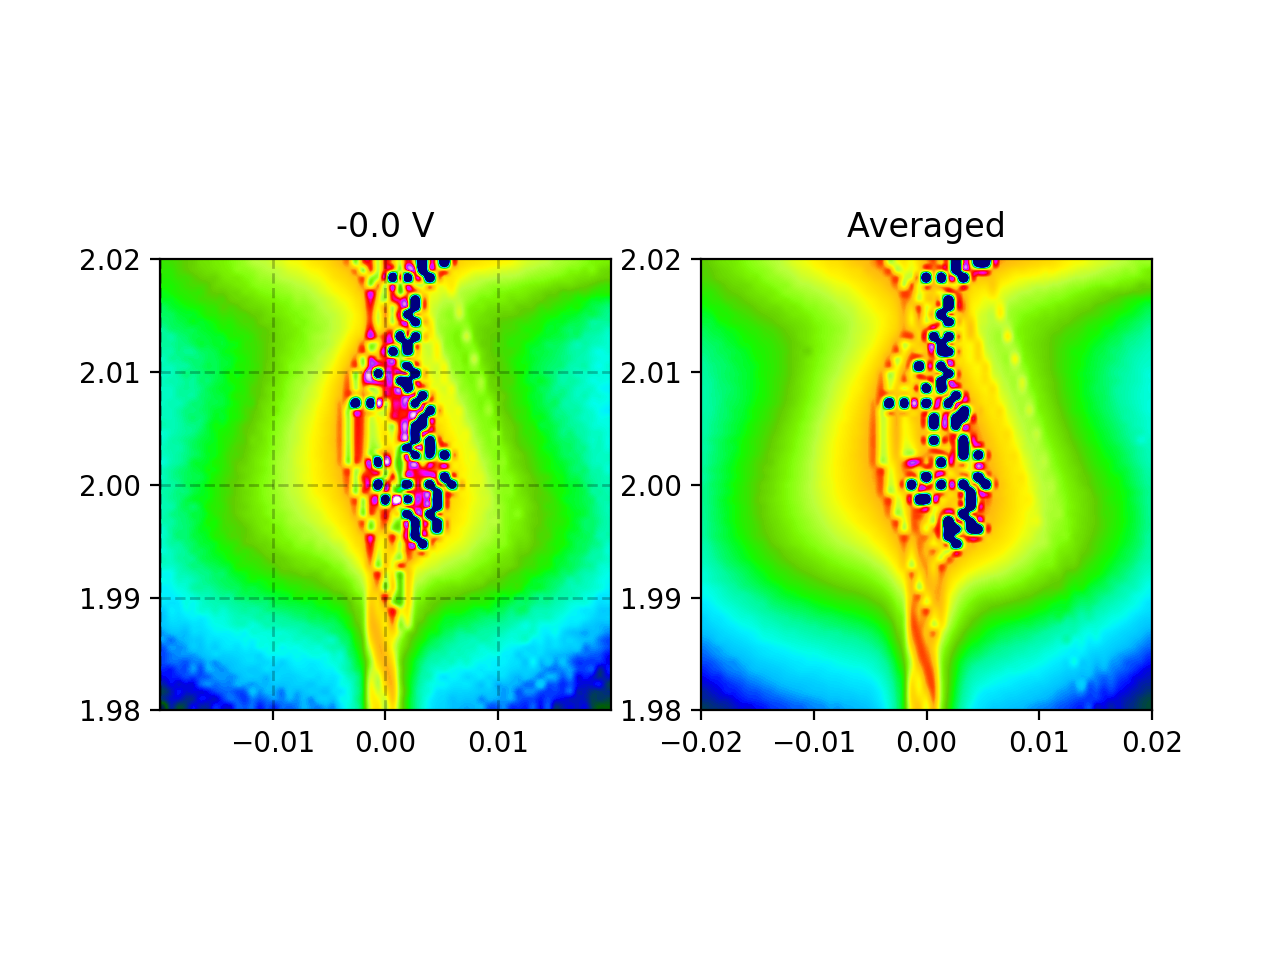

Text(0.5,1.05,'Averaged')

In [23]:
import matplotlib.animation as animation

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

fig, axs = plt.subplots(1,2)
ims = []

# Add grid lines
[axs[0].hlines(0.01*num+1.98, -0.02, 0.02, linestyle = 'dashed', linewidth = 1, alpha = '0.25') and 
 axs[0].vlines(0.01*num-0.02, 1.98, 2.02, linestyle = 'dashed', linewidth = 1, alpha = '0.25') 
 for num in range(4)]

# Create list of images with applied voltages 
for num, V  in zip(range(64),Vs):
    Z = np.reshape(CorrNewPV[num][:3721],[61,61])        
    im = axs[0].imshow(np.log(Z), interpolation= 'spline16', vmax = 12.95, vmin = 4, cmap = 'gist_ncar' , extent = (-0.02, 0.02, 1.98, 2.02),origin = 'lower')
    axs[0].set_xticks((-.01, 0 ,.01))
    title = axs[0].text(0.5,1.05,"{} V".format(V), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=axs[0].transAxes)

    ims.append([im, title])

ani1 = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=100)

ani1.save('Corrected_003.mp4')

plt.show()

axs[1].imshow(np.log(np.reshape(AVint,(61,-1))), interpolation= 'spline16', vmax = 16.3, vmin = 8.2, cmap = 'gist_ncar' , extent = (-0.02, 0.02, 1.98, 2.02),origin = 'lower')
axs[1].text(0.5,1.05,"Averaged",  size=plt.rcParams["axes.titlesize"], ha="center", transform=axs[1].transAxes)


In [ ]:
ani1.event_source.stop()